In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [2]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_stocks.csv')

In [3]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset = dataset.loc[(dataset['Symbol'] == "AMT")]
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
108866,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0
108867,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0
108868,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0
108869,2010-01-07,AMT,33.818180,44.290001,44.570000,44.009998,44.430000,2615000.0
108870,2010-01-08,AMT,33.886909,44.380001,44.570000,44.009998,44.380001,1934600.0
...,...,...,...,...,...,...,...,...
112615,2024-11-25,AMT,207.550003,207.550003,208.039993,204.699997,205.470001,3605900.0
112616,2024-11-26,AMT,208.000000,208.000000,208.830002,205.369995,206.570007,1791400.0
112617,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0
112618,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
dataset = dataset.drop(columns=['Adj Close', "Volume", "Close", "Open", "Low", "High"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,Symbol,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago
0,2011-06-15,AMT,734303,50.750000,2,6,2011,166,24,0,0,2,2,528,52.715000,51.715000,43.584999
1,2011-06-16,AMT,734304,50.355001,3,6,2011,167,24,0,0,2,2,529,52.095001,51.875000,43.825001
2,2011-06-17,AMT,734305,50.419998,4,6,2011,168,24,0,0,2,2,530,52.334999,51.780001,44.165001
3,2011-06-20,AMT,734308,50.420000,0,6,2011,171,25,0,0,2,2,533,52.930000,51.440001,44.289999
4,2011-06-21,AMT,734309,51.355001,1,6,2011,172,25,0,0,2,2,534,52.915001,51.350000,44.289999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,2024-11-25,AMT,739215,206.369995,0,11,2024,330,48,0,0,4,3,5440,219.500000,206.590004,192.029999
3385,2024-11-26,AMT,739216,207.099998,1,11,2024,331,48,0,0,4,3,5441,226.549995,203.910004,192.119995
3386,2024-11-27,AMT,739217,208.750000,2,11,2024,332,48,0,0,4,3,5442,228.930000,203.169998,192.995003
3387,2024-11-29,AMT,739219,208.650002,4,11,2024,334,48,0,0,4,3,5444,225.404999,199.380005,191.580002


In [5]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [6]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [7]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [8]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(blockDf['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = blockDf[blockDf['Date'] < train_max_day].shape[0]
    testSamples = len(blockDf.index) - trainSamples

    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test, blockDf

In [9]:
def getTestSet(dataset0, blockDf0, daysRange):
    min_date = pd.to_datetime(blockDf0['Date'].max())
    max_date = min_date + pd.DateOffset(days=daysRange)
    filtered_df = dataset0[(dataset0['Date'] >= min_date) & (dataset0['Date'] <= max_date)]
    aux = filtered_df.copy()
    aux = aux.drop("Date", axis=1)
    X_test = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test = aux.copy()

    return X_test, Y_test

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

testRanges = [30, 90, 180, 365, 730, 1825]

def getRmse(dataset01, blockDf01, rfModel, testRangesIdx):
    X_test0, Y_test0 = getTestSet(dataset01, blockDf01, testRanges[testRangesIdx])
    y_pred = rfModel.predict(X_test0)
    rmse01 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse01

def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
    return rmse0

def testTfAndGetRmse(dataset0, daysOfBlocks0, daysOfTraining0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    return rmse0

def testTfAndGetRmse2(dataset0, daysOfBlocks0, daysOfTraining0, block_size0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    rmseList0 = [rmse0]
    for i in [0, 1, 2]:
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[i])
        rfts.fit(X_train0, Y_train0)
        rmse1 = dict()
        rmse1[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
        rmse1[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
        rmse1[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
        rmse1[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
        rmse1[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
        rmse1[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
        rmseList0.append(rmse1)
    return rmseList0

def getGraphData(presitionDataArray, bRfp, bs):
    all_arr = [bRfp]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in bs:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(presitionDataArray[blockSize][r])

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

def convertListOfDictToDictOfList(dictList0):
    newDict = dict()
    for dict0 in dictList0:
        for key in dict0:
            if key not in newDict:
                newDict[key] = []
            newDict[key].append(dict0[key])
    return newDict

def runTestsAndGetResults(DaysRange, DaysTrainRange, blockSizes):

    daysOfBlocks = DaysRange
    daysOfTraining = DaysTrainRange
    for i in range(len(blockSizes)):
        blockSizes[i] = int(blockSizes[i])

    basicRFPrecision = []
    for i in range(50):
        rmse = testTfAndGetRmse(dataset, DaysRange, DaysTrainRange)
        basicRFPrecision.append(rmse)
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)

    precisionNonOverlapping = dict()
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
            precisionNonOverlapping[block_size].append(rmse0)
    
    precisionMovingBlock = dict()
    for block_size in blockSizes:
        precisionMovingBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
            precisionMovingBlock[block_size].append(rmse0)
    
    precisionCircularBlock = dict()
    for block_size in blockSizes:
        precisionCircularBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
            precisionCircularBlock[block_size].append(rmse0)
    
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size])
        precisionMovingBlock[block_size] = convertListOfDictToDictOfList(precisionMovingBlock[block_size])
        precisionCircularBlock[block_size] = convertListOfDictToDictOfList(precisionCircularBlock[block_size])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [11]:
def runTestsAndGetResults2(DaysRange, DaysTrainRange, blockSizes):

    basicRFPrecision = []
    precisionNonOverlapping = dict()
    precisionMovingBlock = dict()
    precisionCircularBlock = dict()
    block_size = blockSizes[0]
    precisionNonOverlapping[block_size] = []
    precisionMovingBlock[block_size] = []
    precisionCircularBlock[block_size] = []
    for i in range(50):
        rmseList = testTfAndGetRmse2(dataset, DaysRange, DaysTrainRange, block_size)
        basicRFPrecision.append(rmseList[0])
        precisionNonOverlapping[block_size].append(rmseList[1])
        precisionMovingBlock[block_size].append(rmseList[2])
        precisionCircularBlock[block_size].append(rmseList[3])
    
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)
        
    for block_size0 in blockSizes:
        precisionNonOverlapping[block_size0] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size0])
        precisionMovingBlock[block_size0] = convertListOfDictToDictOfList(precisionMovingBlock[block_size0])
        precisionCircularBlock[block_size0] = convertListOfDictToDictOfList(precisionCircularBlock[block_size0])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [12]:
# bs = [1415]
# FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(365 + max(testRanges), 365, bs)
# #runTestAndCompareOneSigleBlockSize(365, 1415)

In [13]:
def getLinesGraphData(rfReference):
    ticks0 = []
    rfReferenceMeans = []
    for key in rfReference:
        ticks0.append(str(key))
        rfReferenceMeans.append(sum(rfReference[key]) / len(rfReference[key]))
    rfReferenceMeans
    return rfReferenceMeans, ticks0

def showGraphLinesForOneBlockSize(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, descr):
    all_arr0, ticksNames = getLinesGraphData(basicRFPrecision)
    all_arr, ticksNames = getLinesGraphData(precisionNonOverlapping)
    all_arr1, ticksNames = getLinesGraphData(precisionMovingBlock)
    all_arr2, ticksNames = getLinesGraphData(precisionCircularBlock)

    plt.figure()

    bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
    bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    #bp3.colo
    # set_box_color(bp3, '#f03b20')
    # set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    # set_box_color(bp1, '#2C7BB6')
    # set_box_color(bp2, '#fdc086')

    plt.legend()

    plt.xticks(range(0, len(ticksNames)), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre algoritmos ({descr})")
    plt.xlabel("Dias del conjunto de pruebas")
    plt.ylabel("RMSE")

In [14]:
def runTestAndCompareOneSigleBlockSize2(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults2(TrainDays + max(testRanges), TrainDays, bs)
    graphDescr = f"Train: {TrainDays} días, 50 pruebas, bloques {bSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize],graphDescr)

In [15]:
X_train, Y_train, X_test, Y_test, blockDf = getRandomTrainTestData(dataset, 700, 365)
bSize = int(X_train.shape[0] // 10) # Bloques 10% muestras
print(bSize)

25


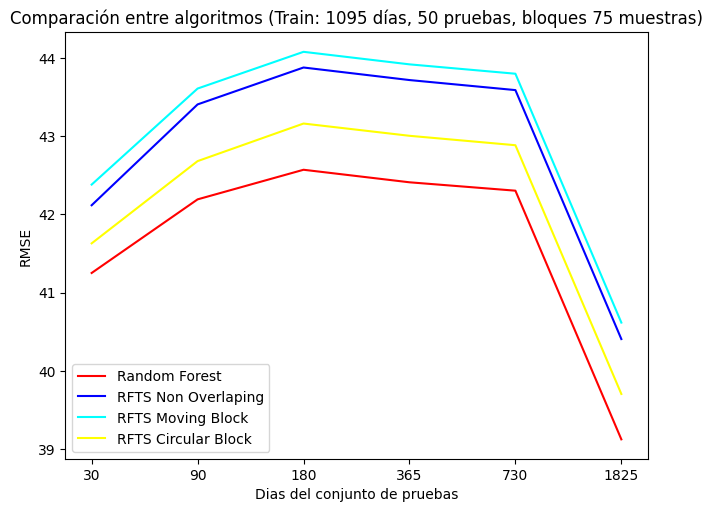

In [16]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), int(bSize * 3))

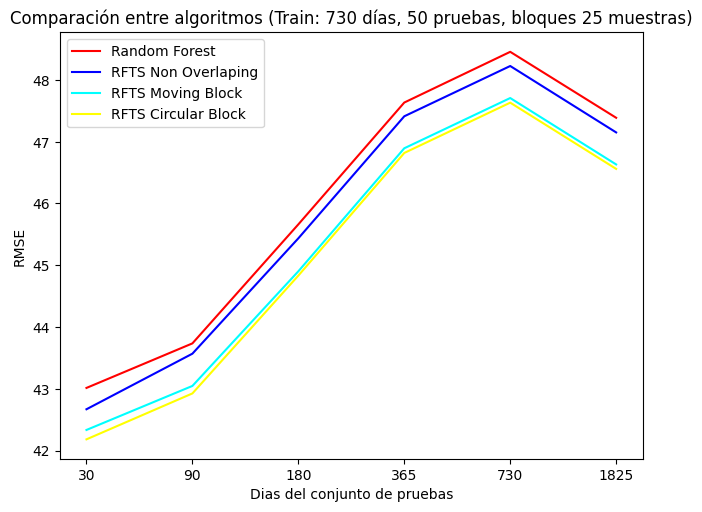

In [17]:
runTestAndCompareOneSigleBlockSize2(365 * 2, bSize)

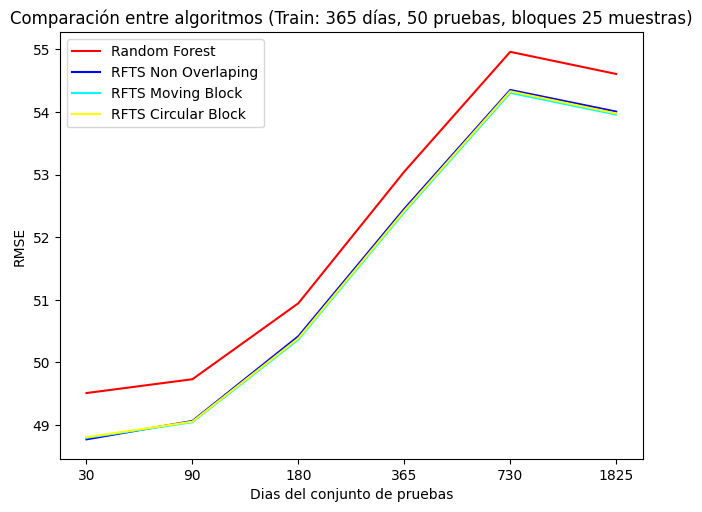

In [18]:
runTestAndCompareOneSigleBlockSize2(365, bSize)

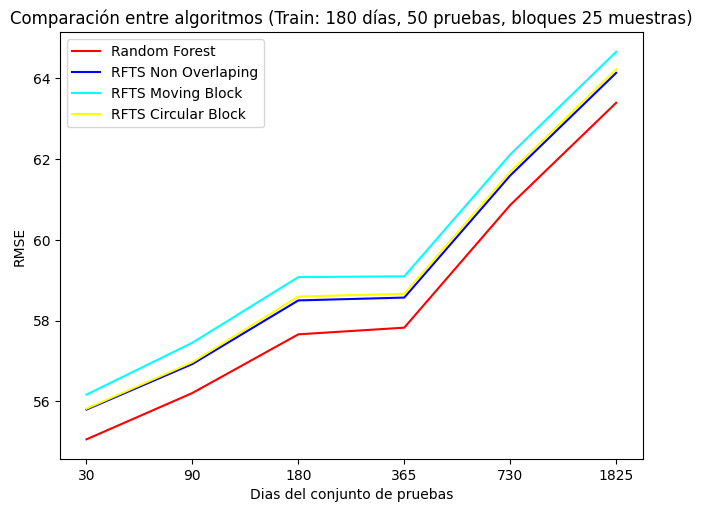

In [19]:
runTestAndCompareOneSigleBlockSize2(180, bSize)

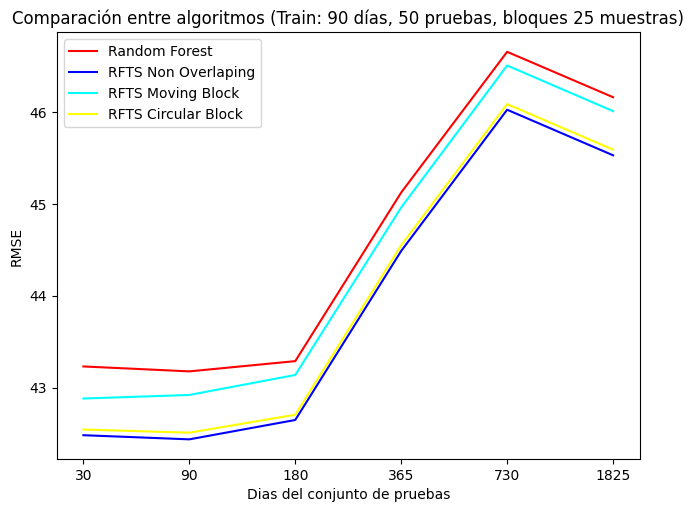

In [20]:
runTestAndCompareOneSigleBlockSize2(90, bSize)

In [ ]:
runTestAndCompareOneSigleBlockSize2(30, int(bSize / 3))

In [ ]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), int(bSize * 2))

NameError: name 'showGraphLinesForOneBlockSize' is not defined

In [ ]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), (bSize * 5))